# Solve time dependent Schroedinger equation in 1D, using FFT method
Shaking harmonic oscillator 1 (dipole oscillations)

In [17]:
import numpy as np
from scipy.fftpack import fft, ifft
from scipy.integrate import simps # 'simps' is Simpson's Rule for integrating

In [18]:
import matplotlib.pyplot as plt

In [19]:
%matplotlib inline

The general solution follows the method of http://jakevdp.github.com/blog/2012/09/05/quantum-python/

* Use the potential to propagate a half time step in x space
* FFT
* Use the kinetic energy operator to propagate one whole time step in k space
* IFFT
* Use the potential to propagate a half time step in x space

For time varying potentials, the propagation term is exp(-i integral(V(x),dt)/hbar).  The integral can be done analytically or numerically.  Here, if numerical integration is used, we use one step of the trapezoidal approximation.  This may not work if the time step is too large.

Hard boundaries are assumed.  Be sure xmin and xmax are sufficiently far from the region of interest for the initial state you choose.

In [20]:
#constants (change these to fit the problem)
hbar = 1
m = 1 #mass
tmin = 0 # initial time
tmax = 10*2*np.pi # final time
Nt = 2000 # number of time steps
xmin = -10 # minimum x value
xmax = 10 # maximum x value
Nx = 2048 # number of steps in x (and k).  Must be even, power of 2 is better

In [21]:
#calculate lists
xlist = np.linspace(xmin,xmax,Nx)
tlist = np.linspace(tmin,tmax,Nt)
dx = xlist[1]-xlist[0] # delta x
dt = tlist[1]-tlist[0] # delta t
dk = 2 * np.pi/np.abs(xmax-xmin) # delta k (from FFT definition)
kmax = 0.5*Nx*dk # (Nyquist limit)
klist = np.roll(np.arange(-Nx//2+1,Nx//2+1),Nx//2+1)*dk #list of k values, indexed according to FFT convention, double // means integer part of quotient

The potential below is a harmonic oscillator potential with sinusoidally varying center position.

Try playing around with the value of f to see how the system behaves.  An interesting range is between 0.2 and 3.0.

In [22]:
#define potential function (needs to be vectorizable)
a=5.0 #amplitude of spring modulation
f=0.2 # frequency of spring modulation
def V(x,t):
    return 0.5*(x-a*np.sin(f*t))**2


In [23]:
# integral of V dt, evaluated at x
def intV(x,ti,tf):
    # first define the indefinite integral of V dt
    #indef = lambda x,t: 0.5*(x**2*t+2*a/f*np.cos(f*t)+0.5*a**2*(t-0.5/f*np.sin(2*f*t)))
    #out = indef(x,tf)-indef(x,ti)
    out = 0.5*(V(x,ti)+V(x,tf))*(tf-ti) #trapezoidal rule (backup plan)
    return out

In [24]:
#initial wavefunction at t=tmin (normalization optional)
def psi0(x):
    a=2.0 #initial displacement
    # this should be the ground state wavefunction, but it needs a bit of a fudge factor to be stationary under the numerical approximations
    return np.exp(-np.sqrt(0.505)*(x-a)**2)/np.pi**(0.25)

In [25]:
psilist = np.zeros([Nx,Nt],dtype=np.cfloat) # initialize array to store wavefunction

In [26]:
psilist[:,0]=psi0(xlist) # store initial wavefunction

In [27]:
#main loop
for tindex in np.arange(1,Nt):
    psix = psilist[:,tindex-1]*np.exp(-1.j*intV(xlist,tlist[tindex-1],tlist[tindex]+0.5*dt)/hbar)
    psix[0:3] = 0; psix[-4:-1] = 0; # enforce boundary conditions
    psik = fft(psix)
    psik = psik * np.exp(-0.5j*hbar*klist*klist*dt/m)
    psix = ifft(psik)
    psix = psix*np.exp(-1.j*intV(xlist,tlist[tindex]-0.5*dt,tlist[tindex])/hbar)
    psix[0:3] = 0; psix[-4:-1] = 0; # enforce boundary conditions
    psilist[:,tindex] = psix

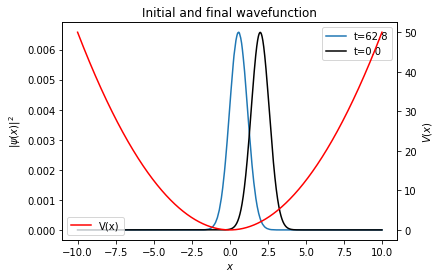

In [28]:
tdraw = -1 # time index for plot (-1 is last time)
Nf = simps(np.abs(psilist[:,tdraw])**2) # normalization of final state
Ni = simps(np.abs(psilist[:,0])**2) # normalization of initial state
fig, ax1 = plt.subplots()
ax1.plot(xlist,np.abs(psilist[:,tdraw])**2/Nf,label='t={0:.1f}'.format(tlist[tdraw]))
ax1.plot(xlist,np.abs(psilist[:,0])**2/Ni,'k',label='t={0:.1f}'.format(tmin))
ax2 = ax1.twinx()
ax2.plot(xlist,V(xlist,0),'r',label='V(x)')
ax1.set_ylabel('$|\psi(x)|^2$')
ax2.set_ylabel('$V(x)$')
ax1.set_xlabel('$x$')
ax1.legend()
ax1.set_title("Initial and final wavefunction")
ax2.legend()

In [29]:
# Calculate expectation values of x, p, x2, p2
EVxlist = np.zeros(Nt)
EVplist = np.zeros(Nt)
EVx2list = np.zeros(Nt)
EVp2list = np.zeros(Nt)
Nlistx = np.zeros(Nt)
Nlistp = np.zeros(Nt)
for t in range(Nt):
    Nlistx[t] = simps(np.abs(psilist[:,t])**2)
    EVxlist[t] = simps(xlist*np.abs(psilist[:,t])**2)/Nlistx[t]
    EVx2list[t] = simps(xlist**2*np.abs(psilist[:,t])**2)/Nlistx[t]-EVxlist[t]**2
    psik = fft(psilist[:,t])
    Nlistp[t] = simps(np.abs(psik)**2)
    EVplist[t] = 0.5*hbar/m*simps(klist*np.abs(psik)**2)/Nlistp[t]
    EVp2list[t] = (simps((0.5*hbar/m*klist)**2*np.abs(psik)**2)/Nlistp[t]-EVplist[t]**2)
Elist = 0.5*EVp2list + 0.5*EVx2list

Text(0.5, 1.0, 'Center of mass and width')

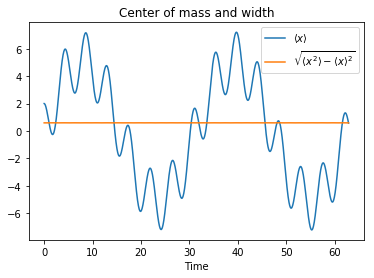

In [30]:
plt.plot(tlist,EVxlist,label=r'$\langle x \rangle$')
plt.plot(tlist,np.sqrt(EVx2list),label=r'$\sqrt{\langle x^2 \rangle-\langle x \rangle ^2}$')
plt.legend()
plt.xlabel('Time')
plt.title('Center of mass and width')

Text(0.5, 1.0, 'Average momentum and momentum width')

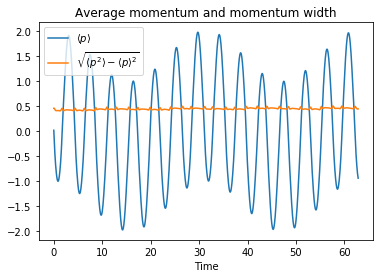

In [31]:
plt.plot(tlist,EVplist,label=r'$\langle p \rangle$')
plt.plot(tlist,np.sqrt(EVp2list),label=r'$\sqrt{\langle p^2 \rangle-\langle p \rangle ^2}$')
plt.legend()
plt.xlabel('Time')
plt.title("Average momentum and momentum width")

Text(0.5, 1.0, 'Energy')

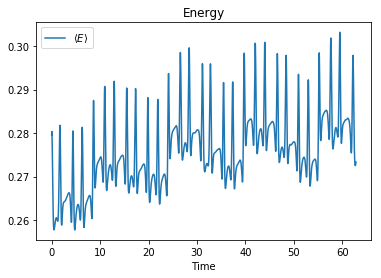

In [32]:
plt.plot(tlist,Elist,label=r'$\langle E \rangle$')
#plt.plot(tlist,np.sqrt(EVx2list),label=r'$\sqrt{\langle x^2 \rangle-\langle x \rangle ^2}$')
plt.legend()
plt.xlabel('Time')
plt.title('Energy')